In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

#sklearn
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator, TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self, X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    class hogtransformer(BaseEstimator,TransformerMixin):
        import skimage.feature
        def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3,3),):
            self.orientations = orientations
            self.pixels_per_cell = pixels_per_cell
            self.cells_per_block = cells_per_block
            
            def fit(self,X,y=None):
                return self
            
            def transform(self,X,y=None):
                def local_hog(img):
                    hog_feature = skimage.feature.hog(img,orientations=self.orientations,
                                                     pixels_per_cell =self.pixel_per_cell,
                                                     cells_per_block=self.cells_per_block)
                    
                    return hog_features
                
                hfeatures = np.array([local_hog(x) for x in X])
                return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#pipeline
image = skimage.io.imread('eagle.jpg')
#transform image into 80x80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
#rgb to gray
gray = skimage.color.rgb2gray(image_transform)
#hog feature
feature_vector = skimage.feature.hog(gray,
                                     orientations=10,
                                     pixels_per_cell=(8,8),cells_per_block=(2,2))



In [5]:
feature_vector

array([0.20979654, 0.02552764, 0.25555313, ..., 0.04803068, 0.0377739 ,
       0.00724294])

In [6]:
#Load the model
import pickle
model = pickle.load(open('pickle files/dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('pickle files/dsa_scaler.pickle','rb'))

In [7]:
model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [8]:
feature_vector.shape

(3240,)

In [9]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [10]:
result

array(['eagle'], dtype='<U8')

In [11]:
# calculating the probablity
decision_value = model.decision_function(scalex)

In [12]:
decision_value

array([[-157.9948244 , -183.58904759, -156.43787669, -133.91655294,
        -251.85538728, -176.48080359,  -30.76382801,   -2.39757119,
        -221.71728238, -162.49297666, -280.1622646 ,  -96.23470676,
        -240.95076492, -215.65793981,  -69.88395928,  -82.38255775,
        -155.07051827, -198.57400427, -178.61328944, -329.64731505]])

In [13]:
model.classes_

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [14]:
decision_value.shape

(1, 20)

In [15]:
labels = model.classes_

In [16]:
decision_value = decision_value.flatten()

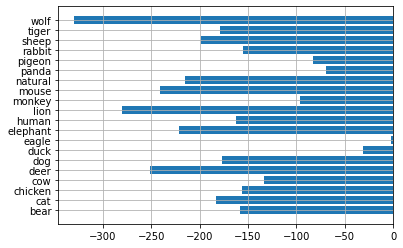

In [17]:
plt.barh(labels,decision_value)
plt.grid()

In [18]:
# calculate z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.03346503, 0.0242865 , 0.03412405, 0.04524505, 0.01032791,
       0.02654801, 0.1647012 , 0.23496451, 0.01506456, 0.03163169,
       0.00724486, 0.07253559, 0.01183944, 0.01625242, 0.10090038,
       0.08627867, 0.03471352, 0.02013031, 0.02584829, 0.00389802])

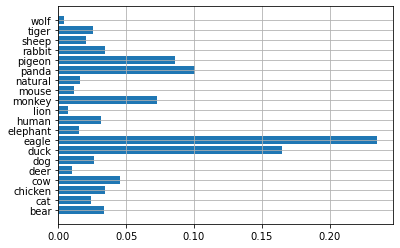

In [19]:
plt.barh(labels,prob_value)
plt.grid()

In [20]:
#top five probab;ity values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [21]:
top_5_prob_ind

array([ 7,  6, 14, 15, 11], dtype=int64)

In [22]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [23]:
top_prob,top_labels

(array([0.23496451, 0.1647012 , 0.10090038, 0.08627867, 0.07253559]),
 array(['eagle', 'duck', 'panda', 'pigeon', 'monkey'], dtype='<U8'))

In [24]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,2)})

In [25]:
top_dict

{'eagle': 0.23, 'duck': 0.16, 'panda': 0.1, 'pigeon': 0.09, 'monkey': 0.07}

In [26]:
def pipeline_model(path,scaler_transform,model_sgd):
    #pipeline
    image = skimage.io.imread(path)
    #transform image into 80x80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    #rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    #hog feature
    feature_vector = skimage.feature.hog(gray,
                                     orientations=10,
                                     pixels_per_cell=(8,8),cells_per_block=(2,2))

    #Scaling
    scalex = scaler.transform(feature_vector.reshape(1,-1))
    result = model.predict(scalex)
    
    #decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    
    #probablity
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    prob_value
    
    #top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    #put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,2)})
        

    return top_dict

In [27]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.23, 'duck': 0.16, 'panda': 0.1, 'pigeon': 0.09, 'monkey': 0.07}